In [1]:
import graphviz
from warnings import filterwarnings

filterwarnings(action='ignore')
graphviz.set_jupyter_format('png')

'svg'

In [2]:
import torch
import matplotlib.pyplot as plt

from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torchvision import transforms, io
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

from forest_cover_change_detection import DigitClassifierDataset
from forest_cover_change_detection import (AttentionWithoutContex,
                                           AttentionWithContex,
                                           FeatureExtractor,
                                           Compile)
from forest_cover_change_detection.models.attention.dot_score import WeightSelector as DotScore
from forest_cover_change_detection.models.attention.general_score import WeightSelector as GeneralScore
from forest_cover_change_detection.models.attention.addative_score import WeightSelector as AdditiveScore
from forest_cover_change_detection.models.attention.simple_score import WeightSelector as SimpleScore

In [3]:
# data augmentation steps to use inside dataloders

train_transform = v2.Compose([v2.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.98, 1.02)),
                              v2.RandomPerspective(distortion_scale=0.5, p=0.5),
                              transforms.ToTensor()])

In [4]:
training_data = DigitClassifierDataset('../../data/exp_data/digit/train',
                                       '../../data/exp_data/digit/train_labels.csv',
                                       9, train_transform)

In [5]:
train_size = int(len(training_data) * 0.8)
test_size = len(training_data) - train_size

train_dataset, test_dataset = random_split(training_data, (train_size, test_size))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

torch.Size([9, 1, 28, 28])
9


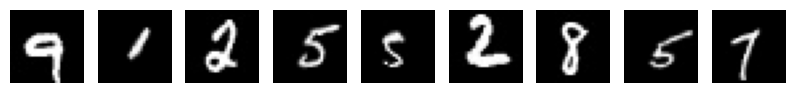

In [6]:
x, y = next(iter(train_dataset))
# x = torch.rand((16, 12, 1, 28, 28))
f, axes = plt.subplots(1, 9, figsize=(10, 10))

print(x.shape)

for i in range(9):
    axes[i].imshow(x[i, 0, :, :].numpy(), cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')

print(y)

## Model building and training

In [7]:
feat_ex = FeatureExtractor(1, 3, 9)

w_slc_d = DotScore(feat_ex.filters[-1])
w_slc_g = GeneralScore(feat_ex.filters[-1])
w_slc_a = AdditiveScore(feat_ex.filters[-1])
w_slc_s = SimpleScore(1, 4, feat_ex.filters[-1], 9)

In [8]:
model = AttentionWithContex(feat_ex, w_slc_a, feat_ex.filters[-1], 10)
compiled = Compile(model,
                   AdamW(model.parameters(), lr=0.001),
                   {'Accuracy': accuracy_score}
                   )

In [10]:
compiled.summary(input_size=(9, 1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
            Conv2d-2           [-1, 16, 14, 14]             160
            Conv2d-3           [-1, 16, 14, 14]             160
            Conv2d-4           [-1, 16, 14, 14]             160
            Conv2d-5           [-1, 16, 14, 14]             160
            Conv2d-6           [-1, 16, 14, 14]             160
            Conv2d-7           [-1, 16, 14, 14]             160
            Conv2d-8           [-1, 16, 14, 14]             160
            Conv2d-9           [-1, 16, 14, 14]             160
 IndividualConv2d-10        [-1, 9, 16, 14, 14]               0
             ReLU-11        [-1, 9, 16, 14, 14]               0
           Conv2d-12             [-1, 32, 7, 7]           4,640
           Conv2d-13             [-1, 32, 7, 7]           4,640
           Conv2d-14             [-1, 3


(dot.exe:16148): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


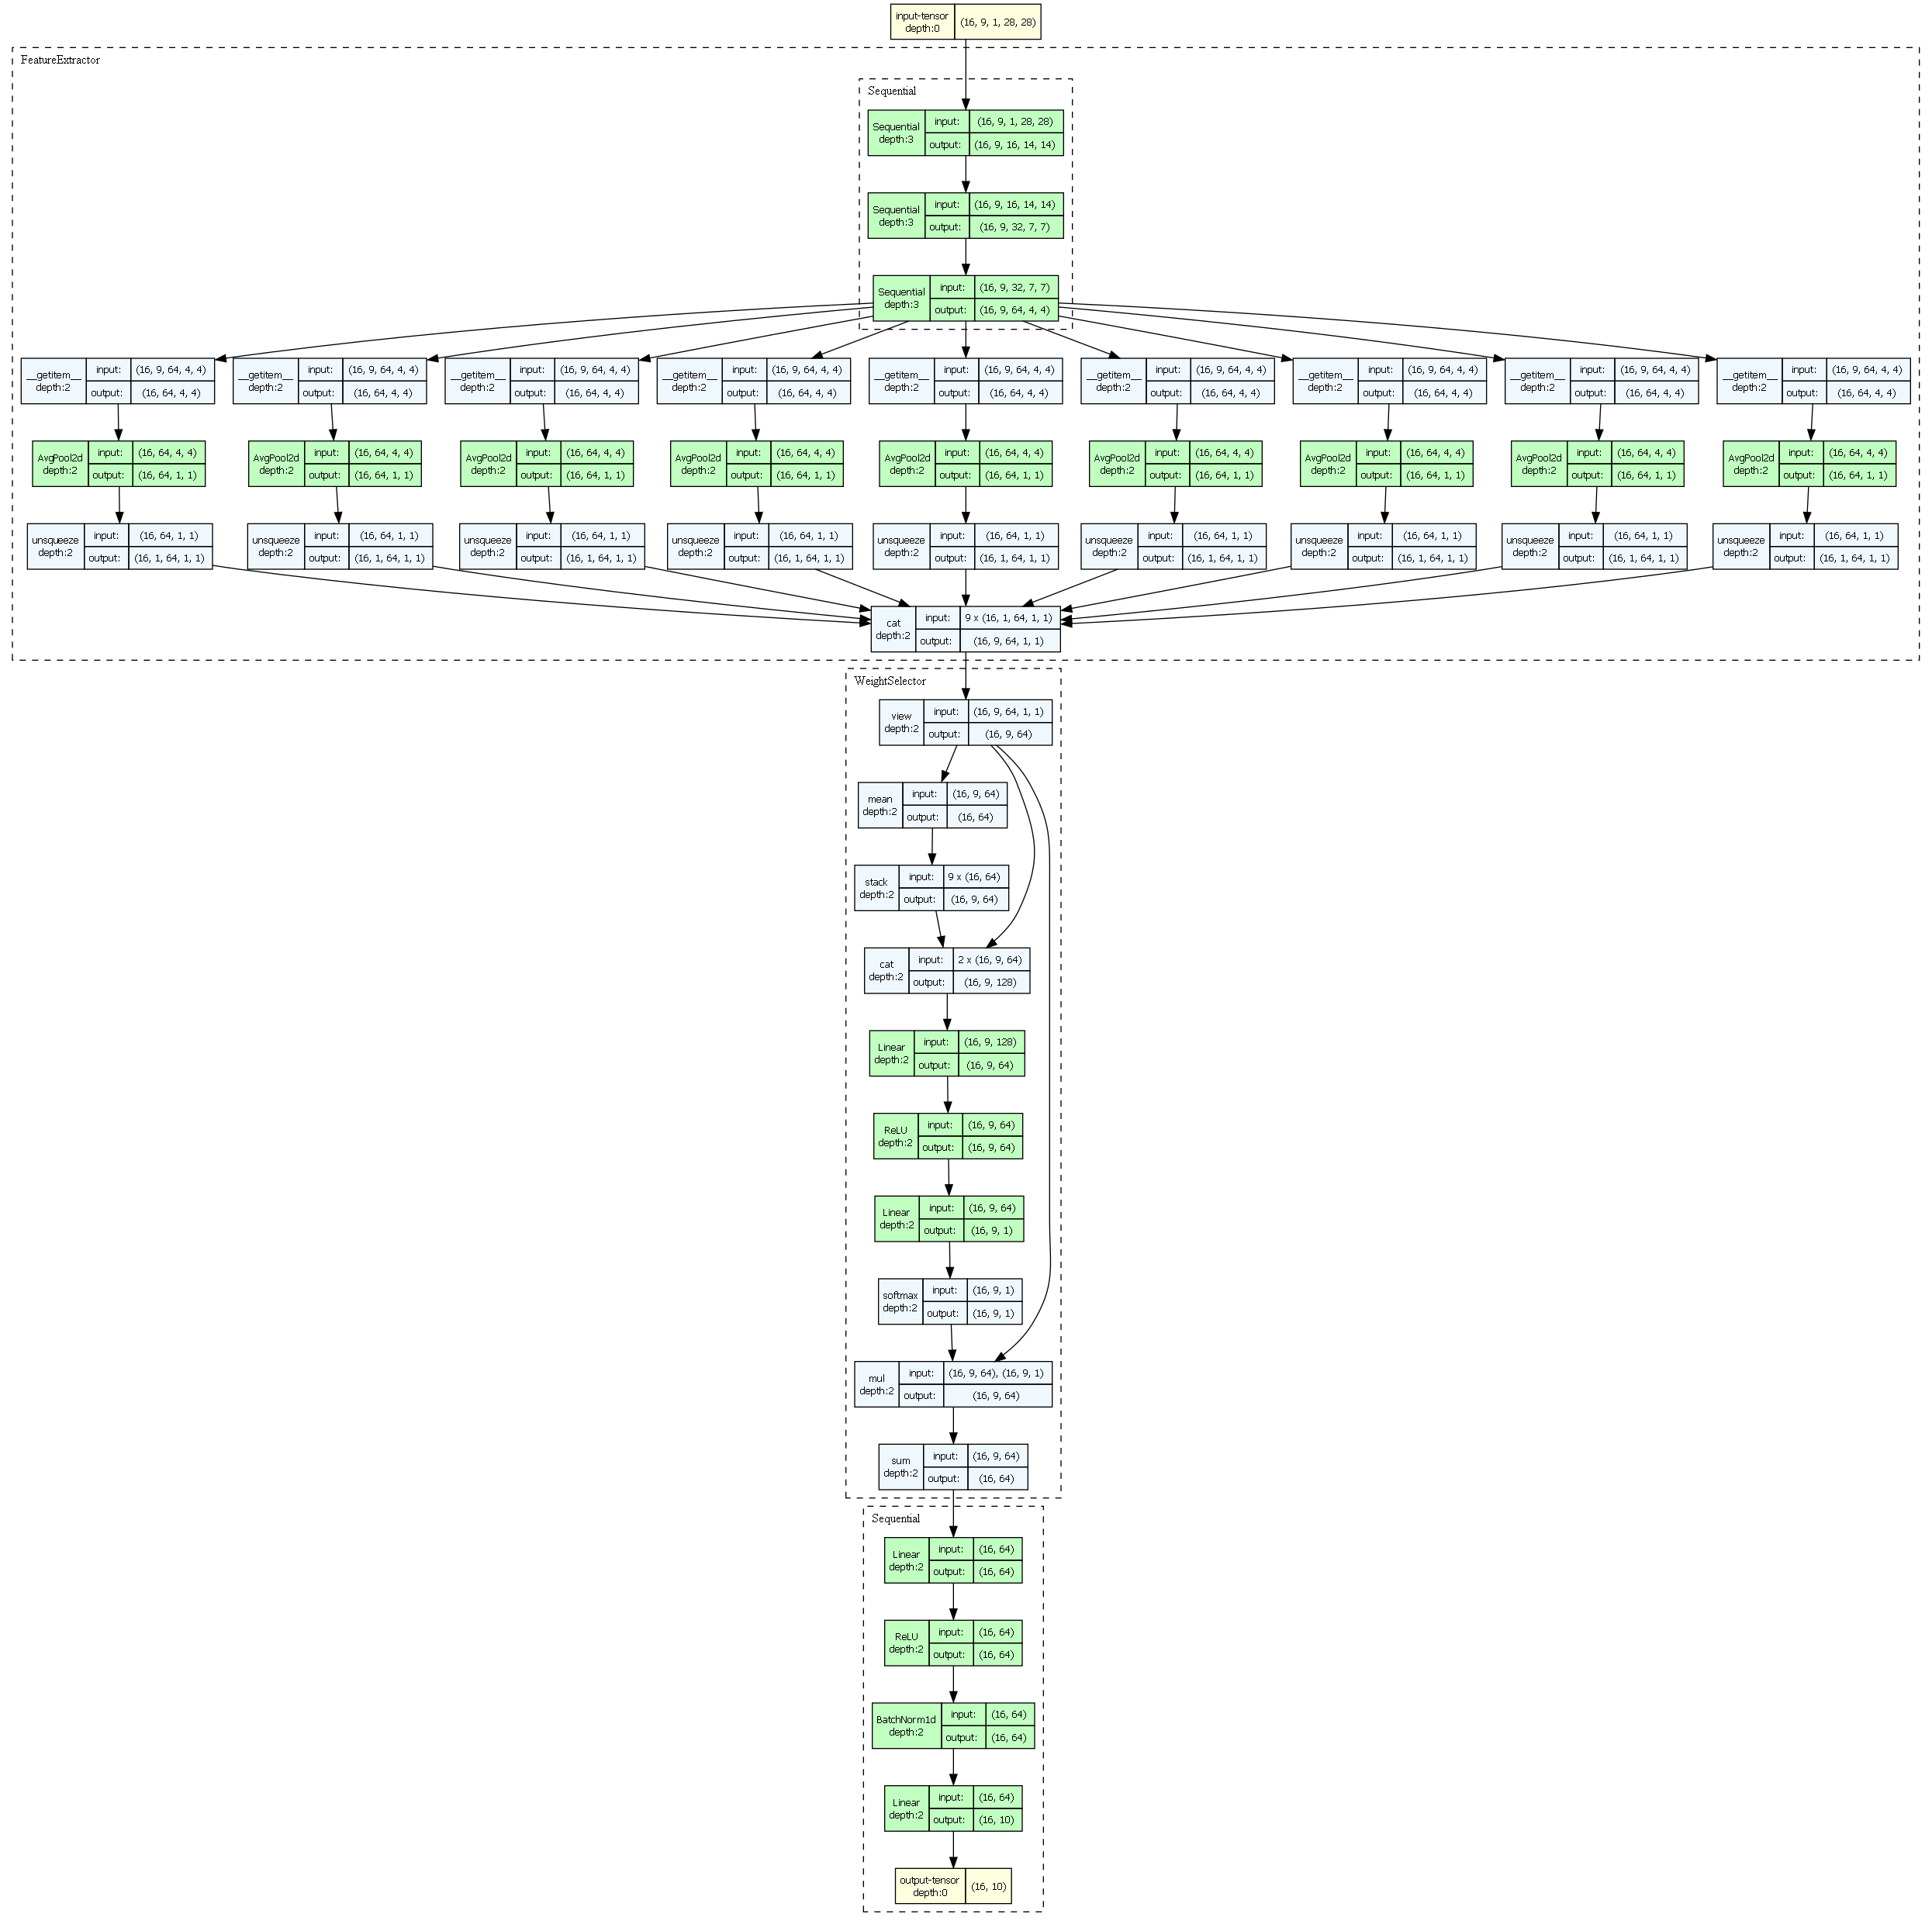

In [11]:
compiled.visual_graph(input_size=(16, 9, 1, 28, 28))

In [13]:
results = compiled.train(train_dataloader, CrossEntropyLoss(), 20, test_dataloader)